In [87]:
import torch
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models


import torch.optim as optim
import torchvision
from torchvision.models import resnet50
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# **Setting Device and Loading the Dataset**

In [88]:

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

NUM_CLASSES = 10

# Hyperparameters
learning_rate = 1e-2
batch_size = 64
data_path = '../data_cifar/'

custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(data_path,
                                 train=True,
                                 transform=custom_transform,
                                 download=True)

test_dataset = datasets.CIFAR10(data_path,
                                train=False,
                                transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Files already downloaded and verified
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])


## **Loading and Modifying the RESNET50 Model**

In [89]:
# Load pretrained ResNet-50 model
model = resnet50(pretrained=True)
num_classes = 10
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [90]:
for param in model.parameters():
    param.requires_grad = False
# Modify the last layer of the ResNet-50 model
num_ftrs = model.fc.in_features

for param in model.layer3.parameters():
    param.requires_grad = True

model.fc = nn.Linear(num_ftrs, num_classes)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [91]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## **Training and testing the Model**

In [92]:
# Training loop
epochs = 10

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds==yb).float().mean()

pbar = tqdm(range(epochs))
start_time = time.time()
for epoch in pbar:
    pbar.set_description(f"Epoch {epoch + 1} / 10")
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('| Epoch : %d | Batch: %5d | loss: %.3f | Accuracy: %.4f |' % (epoch + 1, i + 1, running_loss / 100, accuracy(outputs, labels)))
            running_loss = 0.0
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
print("Finished training")

# Evaluate the model on the test set
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total

print('Accuracy on the test set: %.2f %%' % accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

| Epoch : 1 | Batch:   100 | loss: 1.013 | Accuracy: 0.7656 |
| Epoch : 1 | Batch:   200 | loss: 0.618 | Accuracy: 0.6406 |
| Epoch : 1 | Batch:   300 | loss: 0.532 | Accuracy: 0.9375 |
| Epoch : 1 | Batch:   400 | loss: 0.497 | Accuracy: 0.8281 |
| Epoch : 1 | Batch:   500 | loss: 0.458 | Accuracy: 0.8750 |
| Epoch : 1 | Batch:   600 | loss: 0.453 | Accuracy: 0.8906 |
| Epoch : 1 | Batch:   700 | loss: 0.434 | Accuracy: 0.9062 |
Time elapsed: 6.72 min
| Epoch : 2 | Batch:   100 | loss: 0.293 | Accuracy: 0.9375 |
| Epoch : 2 | Batch:   200 | loss: 0.299 | Accuracy: 0.8750 |
| Epoch : 2 | Batch:   300 | loss: 0.298 | Accuracy: 0.8750 |
| Epoch : 2 | Batch:   400 | loss: 0.323 | Accuracy: 0.9531 |
| Epoch : 2 | Batch:   500 | loss: 0.304 | Accuracy: 0.8906 |
| Epoch : 2 | Batch:   600 | loss: 0.319 | Accuracy: 0.8281 |
| Epoch : 2 | Batch:   700 | loss: 0.324 | Accuracy: 0.9062 |
Time elapsed: 13.43 min
| Epoch : 3 | Batch:   100 | loss: 0.194 | Accuracy: 0.9062 |
| Epoch : 3 | Batch:   

In [93]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits = model(features)
        _, predicted_labels = torch.max(logits, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

## **Results and Analysis**

In [94]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 90.55%


In [95]:
%matplotlib inline
import matplotlib.pyplot as plt

In [96]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break

logits = model(features.to(device))
_, predicted_labels = torch.max(logits, 1)



In [97]:
model_out_path = "model.pth"
torch.save(model, model_out_path)
print("Checkpoint saved to {}".format(model_out_path))

Checkpoint saved to model.pth


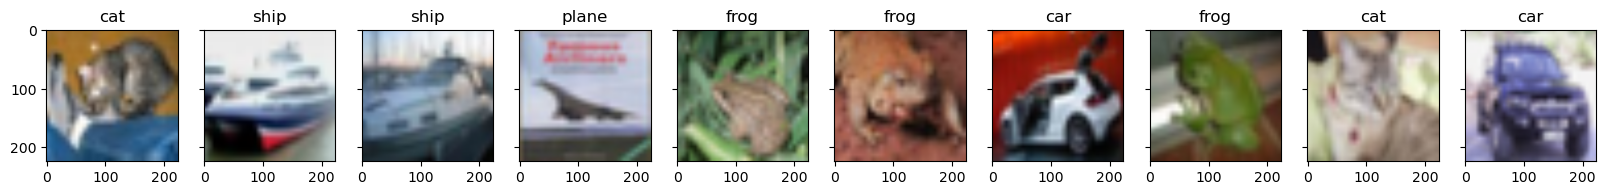

In [98]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

n_images = 10

fig, axes = plt.subplots(nrows=1, ncols=n_images,
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]

for i in range(n_images):
    curr_img = orig_images[i].detach().to(torch.device('cpu'))
    curr_img = unnormalize(curr_img,
                           torch.tensor([0.485, 0.456, 0.406]),
                           torch.tensor([0.229, 0.224, 0.225]))
    curr_img = curr_img.permute((1, 2, 0))
    axes[i].imshow(curr_img)
    axes[i].set_title(classes[predicted_labels[i]])

### Confusion Matrix

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


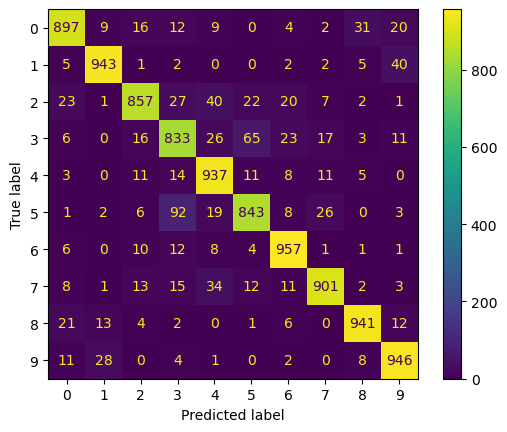

In [101]:
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():

  for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
        #   inputs = inputs.reshape(inputs.shape[0], -1)

          output = model(inputs)

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth


cm = confusion_matrix(y_true,y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix=cm)
matrix.plot()
plt.show()

### Classification Report

In [100]:
#Model accuracy
report = classification_report(y_true,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1000
           1       0.95      0.94      0.94      1000
           2       0.92      0.86      0.89      1000
           3       0.82      0.83      0.83      1000
           4       0.87      0.94      0.90      1000
           5       0.88      0.84      0.86      1000
           6       0.92      0.96      0.94      1000
           7       0.93      0.90      0.92      1000
           8       0.94      0.94      0.94      1000
           9       0.91      0.95      0.93      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



The RESNET50 Model provided an accuracy of 90.55% with time (~ 67 mins)